In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris  # delete me
import matplotlib.pyplot as plt
from tqdm import tqdm

from typing import Optional, Callable

Мне впадул, сорь, поэтому с LabelEncoder сами разберитесь, там будет что-то типа. Про скачивание датасета с sklearn забудьте, сотрите этот позор

In [3]:
# le = LabelEncoder()
# df['class'] = le.fit_transform(df['class'])

iris = load_iris()
data = iris.data
labels = iris.target

Создание даталоадера, чтобы круто, по бачам, модно, молодёжно

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=0, shuffle=True
)

train_dataset = TensorDataset(
    torch.from_numpy(X_train).to(torch.float32),
    torch.from_numpy(y_train).to(torch.int64),
)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

test_dataset = TensorDataset(
    torch.from_numpy(X_test).to(torch.float32), torch.from_numpy(y_test).to(torch.int64)
)
test_loader = DataLoader(test_dataset, batch_size=8)

In [5]:
class MLP(nn.Module):
    # MLP - Mutli-layer Perceptron
    def __init__(self, hidden_layers: Optional[tuple[int]] = None) -> None:
        """Пацаны, эта штука для вас, чтобы понять, сотрите. Как она работает:
        >>> model = MLP()
        Вот наведитесь на скобочки и вылезет подсказка. Если нет, то используете говно
        скачайте VS Code, поставьте Python набор дополнений

        Итак, зачем это говно -> для простого тестирования нескольких скрытых слоёв
        (как я понял, это надо)

        Примеры:
        >>> model = MLP() # без скрытых слоёв
        >>> model = MLP((4,5,4)) # с трёмя скрытыми слоями
        """
        super().__init__()

        # for easy experiments
        if hidden_layers is None:
            self.mlp = nn.Sequential(nn.Linear(in_features=4, out_features=3))
        else:
            self.mlp = nn.Sequential()
            last_layer: int = 4
            for hidden_layer in hidden_layers:
                self.mlp.append(
                    nn.Linear(in_features=last_layer, out_features=hidden_layer)
                )
                self.mlp.append(nn.ReLU())
                last_layer = hidden_layer

            self.mlp.append(nn.Linear(in_features=last_layer, out_features=3))

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.mlp(X)

In [45]:
# для мака сами сделаете
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = MLP((4, 5, 4)).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

model

MLP(
  (mlp): Sequential(
    (0): Linear(in_features=4, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=4, bias=True)
    (5): ReLU()
    (6): Linear(in_features=4, out_features=3, bias=True)
  )
)

In [43]:
# впадлу дублировать код, запихните его в train/test сами
def _shared_step(
    X: torch.Tensor,
    y: torch.Tensor,
    model: nn.Module,
    loss_fn: Callable,
    device: str = "cpu",
) -> tuple[float]:
    X = X.to(device)
    y = y.to(device)
    logits = model(X)
    print(logits)
    print(y)

    loss = loss_fn(logits, y)
    accuracy = sum(torch.argmax(logits.to("cpu"), dim=1) == y.to("cpu")) / len(X)

    return accuracy, loss


In [19]:
def train(
    model: nn.Module,
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    train_loader: DataLoader,
    device: str = "cpu",
) -> list[float]:
    model.train()
    epoch_accuracy = []

    for X, y in tqdm(train_loader):
        accuracy, loss = _shared_step(X, y, model, loss_fn, device)
        epoch_accuracy.append(accuracy)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return epoch_accuracy


def test(
    model: nn.Module, loss_fn: Callable, test_loader: DataLoader, device: str = "cpu"
) -> list[float]:
    model.eval()
    epoch_accuracy = []

    with torch.no_grad():
        for X, y in tqdm(test_loader):
            accuracy, _ = _shared_step(X, y, model, loss_fn, device)
            epoch_accuracy.append(accuracy)

    return epoch_accuracy

In [49]:
num_epochs = 5
train_acc = []
test_acc = []

for i in tqdm(range(num_epochs)):
    train_acc.append(train(model, loss_fn, optimizer, train_loader, device))
    test_acc.append(test(model, loss_fn, test_loader, device))

100%|██████████| 15/15 [00:00<00:00, 366.33it/s]


tensor([[-4.1591, -0.1920, -0.9263],
        [ 4.3998,  0.5188, -7.3762],
        [ 3.8019,  0.4705, -6.7847],
        [-2.5114, -0.0536, -2.0837],
        [-3.0304, -0.0978, -1.7790],
        [-5.1337, -0.2801, -0.9351],
        [-4.2236, -0.2027, -1.4605],
        [-8.4477, -0.5571,  1.5330]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 1, 1, 1, 2])
tensor([[ 4.2357,  0.5104, -6.7841],
        [-6.6096, -0.3930,  0.3420],
        [-7.4245, -0.4642,  0.5379],
        [-7.9699, -0.5130,  0.5067],
        [-5.9958, -0.3429, -0.2927],
        [-2.5468, -0.0498, -2.2445],
        [ 4.4319,  0.5282, -7.1336],
        [ 4.1795,  0.5085, -6.7582]], grad_fn=<AddmmBackward0>)
tensor([0, 2, 2, 2, 1, 1, 0, 0])
tensor([[-2.8071, -0.0639, -1.9481],
        [ 4.2305,  0.5195, -6.8081],
        [-3.6993, -0.1392, -1.3583],
        [-9.5881, -0.6397,  1.8231],
        [-4.4520, -0.2039, -1.0838],
        [-3.4604, -0.1198, -1.6646],
        [ 4.5049,  0.5420, -7.2600],
        [-9.0658, -0.5943,  1

100%|██████████| 4/4 [00:00<00:00, 2849.39it/s]


tensor([[-9.0545, -0.5987,  1.9275],
        [-3.0855, -0.0679, -1.9550],
        [ 4.7911,  0.6232, -7.8558],
        [-8.3530, -0.5318,  1.1387],
        [ 4.4568,  0.5886, -7.2017],
        [-9.8384, -0.6636,  2.0873],
        [ 4.5072,  0.5939, -7.2919],
        [-4.8271, -0.2206, -1.2404]])
tensor([2, 1, 0, 2, 0, 2, 0, 1])
tensor([[-4.9442, -0.2311, -1.1078],
        [-3.5013, -0.1042, -1.8873],
        [-6.2574, -0.3480,  0.2388],
        [-4.4399, -0.1866, -1.4268],
        [-4.0425, -0.1522, -1.4209],
        [-5.0679, -0.2422, -0.9288],
        [-4.6922, -0.2094, -1.0185],
        [ 4.4683,  0.5898, -7.2223]])
tensor([1, 1, 2, 1, 1, 1, 1, 0])
tensor([[-4.8145, -0.2202, -0.9258],
        [-3.8967, -0.1399, -1.2526],
        [ 3.9982,  0.5493, -6.7189],
        [ 4.7155,  0.6157, -7.7114],
        [-7.4057, -0.4495,  1.0489],
        [-4.6931, -0.2099, -0.8627],
        [ 4.1693,  0.5640, -6.8600],
        [ 4.0799,  0.5524, -6.5680]])
tensor([1, 1, 0, 0, 2, 1, 0, 0])
tensor([[-

100%|██████████| 15/15 [00:00<00:00, 410.31it/s]


tensor([[-8.2260, -0.5208,  1.1083],
        [-7.5839, -0.4638,  0.5438],
        [-2.8502, -0.0470, -2.1938],
        [-3.8772, -0.1381, -1.2999],
        [-6.0914, -0.3342,  0.4987],
        [ 4.5692,  0.6004, -7.4028],
        [-3.3891, -0.0946, -1.7873],
        [-8.0750, -0.5073,  0.9314]], grad_fn=<AddmmBackward0>)
tensor([2, 2, 1, 1, 2, 0, 1, 2])
tensor([[-7.1642, -0.4319,  0.5801],
        [-8.5733, -0.5564,  1.2389],
        [ 3.2090,  0.4802, -5.8853],
        [-3.9749, -0.1496, -1.1609],
        [ 4.2317,  0.5711, -6.9142],
        [-2.0126,  0.0252, -2.7092],
        [-4.2152, -0.1709, -1.0046],
        [ 4.5388,  0.5996, -7.3550]], grad_fn=<AddmmBackward0>)
tensor([2, 2, 0, 1, 0, 1, 1, 0])
tensor([[-8.3939, -0.5439,  0.7261],
        [ 4.5572,  0.6041, -7.4015],
        [ 3.8901,  0.5480, -7.0003],
        [-4.7765, -0.2223, -1.0529],
        [-9.2343, -0.6228,  1.9763],
        [ 4.2547,  0.5720, -6.8522],
        [-2.0633,  0.0187, -2.2997],
        [-7.7303, -0.4865,  1

 40%|████      | 2/5 [00:00<00:00, 17.45it/s]

tensor([[ -9.3171,  -0.6316,   2.0013],
        [ -3.2664,  -0.0697,  -1.8925],
        [  4.8644,   0.6831,  -8.0186],
        [ -8.6935,  -0.5681,   1.3266],
        [  4.5329,   0.6446,  -7.3507],
        [-10.1260,  -0.6996,   2.1681],
        [  4.5839,   0.6505,  -7.4424],
        [ -5.0661,  -0.2322,  -1.1390]])
tensor([2, 1, 0, 2, 0, 2, 0, 1])
tensor([[-5.1853, -0.2437, -1.0033],
        [-3.6973, -0.1077, -1.8168],
        [-6.5324, -0.3726,  0.3820],
        [-4.6671, -0.1959, -1.3339],
        [-4.2567, -0.1604, -1.3333],
        [-5.3095, -0.2561, -0.8214],
        [-4.9236, -0.2218, -0.9166],
        [ 4.5452,  0.6460, -7.3728]])
tensor([1, 1, 2, 1, 1, 1, 1, 0])
tensor([[-5.0474, -0.2334, -0.8222],
        [-4.1012, -0.1484, -1.1670],
        [ 4.0141,  0.5965, -6.8256],
        [ 4.7648,  0.6725, -7.8556],
        [-7.7047, -0.4815,  1.2148],
        [-4.9217, -0.2230, -0.7597],
        [ 4.2066,  0.6141, -6.9838],
        [ 4.1387,  0.6030, -6.6920]])
tensor([1, 1, 0, 0,

100%|██████████| 15/15 [00:00<00:00, 222.62it/s]


tensor([[ -4.0980,  -0.1472,  -1.2723],
        [ -6.9308,  -0.4085,   0.5438],
        [-10.2766,  -0.7124,   2.1483],
        [ -8.8176,  -0.5813,   1.6064],
        [ -7.7394,  -0.4827,   1.0156],
        [  4.3987,   0.6289,  -7.1104],
        [ -4.3864,  -0.1695,  -1.5680],
        [ -5.9326,  -0.3162,  -0.1232]], grad_fn=<AddmmBackward0>)
tensor([1, 2, 2, 2, 2, 0, 1, 1])
tensor([[-8.4869, -0.5497,  1.4679],
        [-8.9096, -0.5856,  1.4068],
        [-3.8137, -0.1172, -1.5762],
        [ 4.4971,  0.6503, -7.4912],
        [ 4.2333,  0.6203, -6.9753],
        [ 4.4069,  0.6453, -7.5823],
        [-3.2899, -0.0683, -1.9535],
        [-3.9466, -0.1267, -1.7777]], grad_fn=<AddmmBackward0>)
tensor([2, 2, 1, 0, 0, 0, 1, 1])
tensor([[ -5.9277,  -0.3096,  -0.2744],
        [ -2.9614,  -0.0344,  -2.2108],
        [  4.6506,   0.6673,  -7.5587],
        [ -3.0861,  -0.0477,  -1.9673],
        [ -6.2956,  -0.3501,   0.5745],
        [-11.1700,  -0.7839,   2.3808],
        [  4.4519,   0.6

100%|██████████| 4/4 [00:00<00:00, 217.05it/s]


tensor([[ -9.3932,  -0.6371,   2.0234],
        [ -3.1500,  -0.0322,  -2.0936],
        [  5.0429,   0.7637,  -8.3025],
        [ -8.6406,  -0.5541,   1.1668],
        [  4.6791,   0.7164,  -7.6047],
        [-10.2097,  -0.7058,   2.1924],
        [  4.7323,   0.7233,  -7.6997],
        [ -4.9542,  -0.1980,  -1.3483]])
tensor([2, 1, 0, 2, 0, 2, 0, 1])
tensor([[-5.0785, -0.2110, -1.2068],
        [-3.5766, -0.0695, -2.0270],
        [-6.4700, -0.3539,  0.2267],
        [-4.5523, -0.1606, -1.5439],
        [-4.1485, -0.1266, -1.5312],
        [-5.2103, -0.2255, -1.0159],
        [-4.8252, -0.1913, -1.1070],
        [ 4.6922,  0.7181, -7.6281]])
tensor([1, 1, 2, 1, 1, 1, 1, 0])
tensor([[-4.9523, -0.2038, -1.0091],
        [-4.0049, -0.1176, -1.3479],
        [ 4.2458,  0.6731, -7.1224],
        [ 4.9722,  0.7545, -8.1537],
        [-7.6664, -0.4701,  1.0821],
        [-4.8313, -0.1947, -0.9393],
        [ 4.3983,  0.6878, -7.2546],
        [ 4.2879,  0.6694, -6.9406]])
tensor([1, 1, 0, 0,

tensor([[-1.9396,  0.0788, -2.5805],
        [-9.7214, -0.6595,  1.9640],
        [-9.4261, -0.6363,  2.0076],
        [ 4.7691,  0.7280, -7.7655],
        [-2.4831,  0.0300, -2.4219],
        [-6.3094, -0.3300, -0.3633],
        [-9.6304, -0.6429,  1.4530],
        [-9.4404, -0.6311,  1.6986]], grad_fn=<AddmmBackward0>)
tensor([1, 2, 2, 0, 1, 1, 2, 2])
tensor([[-5.8917, -0.2910, -0.4044],
        [-4.2432, -0.1262, -1.8150],
        [-8.1777, -0.5179,  1.4687],
        [-7.2665, -0.4224,  0.4484],
        [-5.0850, -0.2092, -1.1549],
        [-4.1101, -0.1120, -1.9784],
        [-4.6833, -0.1718, -1.3501],
        [-1.7707,  0.1016, -2.8745]], grad_fn=<AddmmBackward0>)
tensor([2, 1, 2, 2, 1, 1, 1, 1])
tensor([[-6.1675e+00, -3.1498e-01, -2.1702e-01],
        [ 5.1469e+00,  7.8852e-01, -8.5163e+00],
        [-7.6470e+00, -4.6279e-01,  1.0139e+00],
        [ 4.8398e+00,  7.4758e-01, -7.8958e+00],
        [-7.9101e+00, -4.8368e-01,  9.5108e-01],
        [-7.6659e+00, -4.6071e-01,  8.2268e

100%|██████████| 15/15 [00:00<00:00, 303.06it/s]


tensor([[ 4.8338,  0.7878, -7.9016],
        [ 4.9940,  0.8106, -8.2069],
        [-4.4053, -0.1345, -1.2855],
        [-8.6110, -0.5295,  0.5501],
        [-9.2447, -0.6140,  1.8319],
        [-9.1104, -0.5912,  1.3640],
        [-9.3900, -0.6202,  1.5979],
        [-6.7281, -0.3694,  0.4010]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 2, 2, 2, 2, 2])
tensor([[-3.6326, -0.0574, -1.8742],
        [-6.0773, -0.3030, -0.1985],
        [ 4.5070,  0.7481, -7.3680],
        [-3.1764, -0.0160, -2.0071],
        [ 4.8123,  0.7866, -7.8653],
        [ 4.4433,  0.7345, -7.2034],
        [-9.7680, -0.6673,  2.0682],
        [ 4.9384,  0.8045, -8.0993]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 0, 0, 2, 0])


 80%|████████  | 4/5 [00:00<00:00, 15.48it/s]

tensor([[ -9.6574,  -0.6639,   2.0910],
        [ -3.3356,  -0.0287,  -2.0346],
        [  5.1137,   0.8325,  -8.4730],
        [ -8.9846,  -0.5858,   1.3502],
        [  4.7536,   0.7806,  -7.7607],
        [-10.4991,  -0.7352,   2.2665],
        [  4.8077,   0.7883,  -7.8577],
        [ -5.1982,  -0.2041,  -1.2509]])
tensor([2, 1, 0, 2, 0, 2, 0, 1])
tensor([[-5.3243, -0.2183, -1.1064],
        [-3.7777, -0.0676, -1.9600],
        [-6.7487, -0.3742,  0.3662],
        [-4.7845, -0.1644, -1.4548],
        [-4.3674, -0.1297, -1.4473],
        [-5.4564, -0.2342, -0.9124],
        [-5.0612, -0.1987, -1.0088],
        [ 4.7675,  0.7826, -7.7856]])
tensor([1, 1, 2, 1, 1, 1, 1, 0])
tensor([[-5.1897, -0.2119, -0.9091],
        [-4.2139, -0.1214, -1.2656],
        [ 4.2543,  0.7273, -7.2320],
        [ 5.0260,  0.8205, -8.3098],
        [-7.9689, -0.4982,  1.2447],
        [-5.0645, -0.2032, -0.8398],
        [ 4.4306,  0.7453, -7.3832],
        [ 4.3438,  0.7273, -7.0693]])
tensor([1, 1, 0, 0,

tensor([[-7.1583, -0.4126,  0.5337],
        [-9.5221, -0.6397,  1.7094],
        [ 4.7146,  0.7834, -7.8888],
        [-8.8097, -0.5760,  1.5439],
        [-7.7084, -0.4596,  0.5704],
        [ 4.9850,  0.8138, -8.2007],
        [ 4.6257,  0.7745, -7.8171],
        [ 4.9792,  0.8129, -8.1885]], grad_fn=<AddmmBackward0>)
tensor([2, 2, 0, 2, 2, 0, 0, 0])
tensor([[-6.7920, -0.3766,  0.2044],
        [-6.1756, -0.3168, -0.1162],
        [-4.5509, -0.1421, -1.6498],
        [-8.9206, -0.5847,  1.3804],
        [-8.8318, -0.5612,  0.7378],
        [ 4.6325,  0.7646, -7.5443],
        [ 4.6072,  0.7610, -7.4987],
        [-4.4168, -0.1267, -1.8157]], grad_fn=<AddmmBackward0>)
tensor([2, 1, 1, 2, 2, 0, 0, 1])
tensor([[-9.3763, -0.6367,  1.8021],
        [-3.7675, -0.0749, -1.7618],
        [ 4.5791,  0.7585, -7.4488],
        [-5.4725, -0.2396, -0.9195],
        [-9.2577, -0.6259,  1.7709],
        [-6.7133, -0.3641, -0.1258],
        [-7.4455, -0.4357,  0.2718],
        [-4.7388, -0.1701, -1

100%|██████████| 5/5 [00:00<00:00, 15.80it/s]

tensor([[-9.7490e+00, -6.6844e-01,  2.1130e+00],
        [-3.2617e+00,  5.2876e-03, -2.1928e+00],
        [ 5.2781e+00,  9.0893e-01, -8.7324e+00],
        [-8.9851e+00, -5.7421e-01,  1.2435e+00],
        [ 4.8905e+00,  8.4892e-01, -7.9932e+00],
        [-1.0600e+01, -7.4038e-01,  2.2908e+00],
        [ 4.9462e+00,  8.5742e-01, -8.0929e+00],
        [-5.1372e+00, -1.7351e-01, -1.4095e+00]])
tensor([2, 1, 0, 2, 0, 2, 0, 1])
tensor([[-5.2672, -0.1890, -1.2602],
        [-3.7033, -0.0331, -2.1238],
        [-6.7323, -0.3580,  0.2569],
        [-4.7198, -0.1327, -1.6149],
        [-4.3058, -0.0994, -1.5987],
        [-5.4057, -0.2068, -1.0584],
        [-5.0100, -0.1714, -1.1519],
        [ 4.9052,  0.8512, -8.0195]])
tensor([1, 1, 2, 1, 1, 1, 1, 0])
tensor([[-5.1415, -0.1855, -1.0491],
        [-4.1605, -0.0938, -1.4035],
        [ 4.4475,  0.7982, -7.4901],
        [ 5.2018,  0.8968, -8.5727],
        [-7.9761, -0.4889,  1.1576],
        [-5.0198, -0.1780, -0.9737],
        [ 4.5966,  0.8

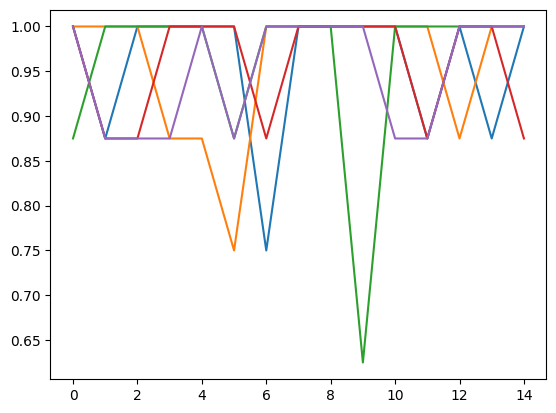

In [50]:
for epoch in train_acc:
    plt.plot(epoch)

In [47]:
X = [1, 2, 3]
logits = torch.Tensor([[5, 2, 1], [2, 4, 8], [3, 7, 9]])
y = torch.Tensor([0, 2, 1])
sum(torch.argmax(logits, dim=1) == y) / len(X)

tensor(0.6667)